In [25]:
#Import
import sys

from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas.io.json import json_normalize

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB

from keras import regularizers
from keras.layers import Dense
from keras.layers import Dropout
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras import optimizers
from keras import losses
from keras import metrics

import nltk
from nltk.corpus import stopwords



In [26]:
data = []
print("Reading in file")

#json_list = ['reviews_Movies_and_TV_5.json','reviews_Amazon_Instant_Video_5.json']
#json_list = ['reviews_Movies_and_TV_5.json'] #Used for big data
json_list = ['reviews_Amazon_Instant_Video_5.json'] # USed for fast testing
counter = 0
for file in json_list:
    counter +=1
    print("On file " + str(counter) + " out of " + str(len(json_list)))
    with open('/Volumes/TOSHIBA/desktop/data_sets/'+ file) as f:
        for line in f:
            data.append(json.loads(line))

            
limit = 500000
print("Shuffle the order, limiting entries to " + str(limit))
shuffle(data)


print("Making df")
df = pd.DataFrame.from_dict(json_normalize(data[:limit]), orient='columns')
    #print(df)
    #df = df.values.tolist()
     
header = df.columns.tolist()
    
        
    # Remove unneeded special characters by encoding to ascii and then recoding to utf-8
df.reviewText = df.reviewText.str.encode('ascii', 'ignore')
df.reviewText = df.reviewText.str.decode('utf-8')
stop_words = set(stopwords.words('english'))
# Removing stopwords - you need a list called stopwords defining your stopwords
df.reviewText = df.reviewText.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    
    
df=df.values
data = list(df)
x_train = []
y_train = []
print("Binning y")
#print(header)
help_count = 0

for i in range(0,(len(data))):
    #print(data[i])
    #input("Press enter to continue")  

    x_train.append(data[i][3])
    if data[i][2] <=3:
        y_train.append(0)
    else:
        y_train.append(1)
value = sum(y_train)
positive = value/len(y_train)
negative = 1 - positive
print("Percent positive reviews: " + str(positive))
print("Percent Negative reviews: " + str(negative))
print("Finished with data")

Reading in file
On file 1 out of 1
Shuffle the order, limiting entries to 500000
Making df
Binning y
Percent positive reviews: 0.7901740020470829
Percent Negative reviews: 0.20982599795291712
Finished with data


In [27]:

print("Vectorizing data, this may take a while depening on the n-gram model and the size of the data")

#CountVectorizer data 0: Unigram, 1: Unigram and Bigram, 2: Bigram
flag = 0 
vectorizer = []
if flag ==0:
#Unigram
    temp = CountVectorizer(min_df=5,analyzer = 'word',stop_words=stop_words,ngram_range=(1,1))
    vectorizer = temp.fit(x_train)
elif flag ==1:
    #Unigram and Bigram
    vectorizer = CountVectorizer(min_df=3,analyzer= 'word',stop_words=stop_words,ngram_range=(1, 2)).fit(x_train)
elif flag ==2:
        #Bigram
    vectorizer = CountVectorizer(min_df=2,analyzer = 'word',stop_words=stop_words,ngram_range=(2, 2)).fit(x_train)

x_train = vectorizer.transform(x_train)


Vectorizing data, this may take a while depening on the n-gram model and the size of the data


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
x_train = TfidfTransformer().fit_transform(x_train)


In [29]:
    print("Splitting data")
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=69, shuffle=True, test_size=0.20)
    y_train = np.asarray(y_train).astype('float32')
    y_test = np.asarray(y_test).astype('float32')
    print("Done splitting data")

Splitting data
Done splitting data


In [46]:
    epochs = 10
    batch_size = 64
    model = models.Sequential()
    model.add(Dense(64, activation='relu',input_shape= (x_train.shape[1],)))
    model.add(Dropout(.20))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(.20))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(x_train,y_train, epochs=epochs,validation_data=((x_test),(y_test)), batch_size=batch_size)


Train on 29700 samples, validate on 7426 samples
Epoch 1/10
29700/29700 [==============================] - 43s 1ms/step - loss: 0.3725 - acc: 0.8377 - val_loss: 0.3415 - val_acc: 0.8484
Epoch 2/10
29700/29700 [==============================] - 39s 1ms/step - loss: 0.2832 - acc: 0.8828 - val_loss: 0.3472 - val_acc: 0.8468
Epoch 3/10
29700/29700 [==============================] - 42s 1ms/step - loss: 0.2525 - acc: 0.8978 - val_loss: 0.3574 - val_acc: 0.8511
Epoch 4/10
29700/29700 [==============================] - 41s 1ms/step - loss: 0.2277 - acc: 0.9094 - val_loss: 0.3686 - val_acc: 0.8472
Epoch 5/10
29700/29700 [==============================] - 44s 1ms/step - loss: 0.2067 - acc: 0.9197 - val_loss: 0.4320 - val_acc: 0.8573
Epoch 6/10
29700/29700 [==============================] - 41s 1ms/step - loss: 0.1894 - acc: 0.9279 - val_loss: 0.4015 - val_acc: 0.8490
Epoch 7/10
29700/29700 [==============================] - 42s 1ms/step - loss: 0.1738 - acc: 0.9351 - val_loss: 0.4361 - val_acc:

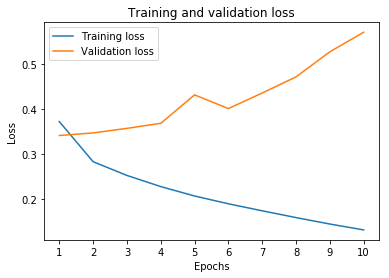

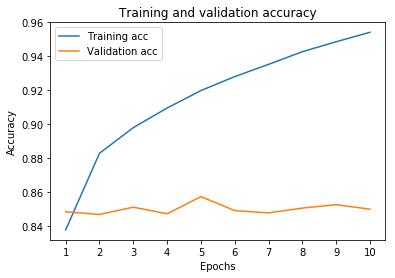

In [47]:
    history_dict = history.history
    loss_values = history_dict['loss']
    loss_values = np.array(loss_values)
    val_loss_values = history_dict['val_loss']
    val_loss_values = np.array(val_loss_values)
    acc_values = history_dict['acc']
    acc_values = np.array(acc_values)
    val_acc_values = history_dict['val_acc']
    val_acc_values = np.array(val_acc_values)

    
    x_labels = list(range(1, len(loss_values) + 1,1))


    #This will show the training and validation loss per epoch
    plt.plot(x_labels, loss_values, label='Training loss')
    plt.plot(x_labels, val_loss_values, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(x_labels)
    plt.legend()
    plt.show()

    #This will show the training and validation accuracy per epoch
    plt.clf()
    plt.plot(x_labels, acc_values, label='Training acc')
    plt.plot(x_labels, val_acc_values, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(x_labels)
    plt.legend()
    plt.show()

In [49]:
epochs = 3
batch_size= 64

model = models.Sequential()
model.add(Dense(64, activation='relu',input_shape= (x_train.shape[1],)))
model.add(Dropout(.20))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.20))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])


model.fit(x_train,y_train, epochs=epochs, batch_size=batch_size)
loss,accuracy = model.evaluate((x_test),(y_test))
print("loss: "+ str(loss))
print("accuracy: "+ str(accuracy))

Epoch 1/3
29700/29700 [==============================] - 17s 578us/step - loss: 0.3880 - acc: 0.8319
Epoch 2/3
29700/29700 [==============================] - 15s 509us/step - loss: 0.2930 - acc: 0.8793
Epoch 3/3
7426/7426 [==============================] - 2s 264us/step
loss: 0.35606170573903645
accuracy: 0.8546997037436036


In [50]:
accuracys = []
accuracys.append(accuracy)

value = sum(y_test)
positive = value/len(y_test)
negative = 1 - positive
print("Percent positive reviews: " + str(positive))
print("Percent Negative reviews: " + str(negative))
print("Finished with data")

size = len(y_test)

listofzeros = [0] * size
accuracy = accuracy_score(y_test, listofzeros)
accuracys.append(accuracy)
del listofzeros


listofones = [1] * size
accuracy = accuracy_score(y_test, listofones)
accuracys.append(accuracy)
del listofones



Percent positive reviews: 0.7857527605709669
Percent Negative reviews: 0.21424723942903312
Finished with data


In [51]:
    print("Running XGBoost")
    model = GradientBoostingClassifier(n_estimators=100)
    model.fit(x_train, y_train)
    results2 = model.predict(x_test)
    accuracy = accuracy_score(y_test, results2)
    accuracys.append(accuracy)

    print("GBC")
    print("accuracy " + str(accuracy))



Running XGBoost
GBC
accuracy 0.8179369781847563


In [52]:
    print("Running LR")
    lrmodel =LogisticRegression(penalty='l2', solver='newton-cg')
    fitmodel =lrmodel.fit(x_train, y_train)
    results = fitmodel.predict(x_test)

    #print(y_test) 
    accuracy = accuracy_score(y_test, results)
    accuracys.append(accuracy)
    print("LR")
    print("accuracy " + str(accuracy))

Running LR
LR
accuracy 0.8565849717209804


In [53]:
    clf = MultinomialNB()
    clf = clf.fit(x_train, y_train)
    scores= (clf.predict(x_test))
    accuracy = accuracy_score(y_test, results2)
    accuracys.append(accuracy)
    print("Multinomial BB")
    print( "Accuracy " + str(accuracy ))
    

Multinomial BB
Accuracy 0.8179369781847563


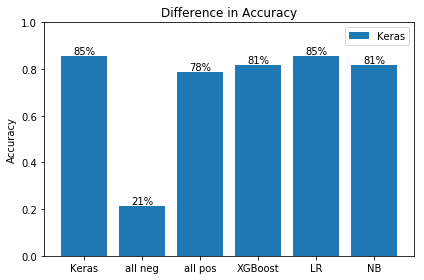

In [54]:
    names = ["Keras","all neg", "all pos","XGBoost","LR", "NB"]
   
   
    
    y_len = np.arange(len(accuracys))
    fig, ax = plt.subplots()

    chart= plt.bar(y_len, accuracys, align='center')#, alpha=0.5)
    plt.xticks(y_len, names)
    plt.ylim(0.0, 1.0)
    plt.ylabel('Accuracy')
    plt.title('Difference in Accuracy')
    plt.legend(names)

    i=0
    for bar in chart:
        height = bar.get_height()
        #print(height)
        ax.text(bar.get_x() + bar.get_width()/2., height,'%d' % int(height*100) + "%", ha='center', va='bottom')

        i+=1
    plt.tight_layout()
    plt.show()

In [ ]:
#Summary of results
'''
From what we can see abouve, using an Unigram, or in this case a bag of words model, 
we get about 85-86% accuracy. A tuned Keras model performs about as well as a untuned LR model. 
Using a Bigram we see slightly better accuracy than Unigram, but again the Keras model 
performs about the same as the LR model. The next step is to take advantage of Keras 
Tokenizer and embedding. Maybe this will let us score better ?

'''